In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import cv2
import torch as t

root = os.getcwd()
dir = 'tiny_vid'
root = os.path.join(root,dir)
data_dir = []
label_dir = []
for each in os.listdir(root):
    if '.txt' in each:
        label_dir.append(each)
    elif '.md' not in each:
        data_dir.append(each)
data_dir,label_dir

(['bird', 'car', 'dog', 'lizard', 'turtle'],
 ['bird_gt.txt', 'car_gt.txt', 'dog_gt.txt', 'lizard_gt.txt', 'turtle_gt.txt'])

In [5]:
img_path = []
bbox_path = []
for each in data_dir:
    for img in os.listdir(os.path.join(root,each))[:180]:
        img_path.append(os.path.join(os.path.join(root,each),img))
        
for each in label_dir:
    bbox_path.append((os.path.join(root,each)))
len(img_path)

900

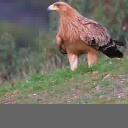

In [6]:
Image.open(img_path[0])

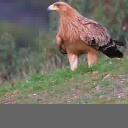

In [7]:
imgs = [Image.open(i)for i in img_path]
imgs[0]

In [8]:
l1 = np.zeros((180,))
l2 = np.ones((180,))
l3 = l2.copy()*2
l4 = l2.copy()*3
l5 = l2.copy()*4

labels = np.concatenate((l1,l2,l3,l4,l5))
labels = t.from_numpy(labels)
labels.size()

torch.Size([900])

In [13]:
for each in bbox_path:
    if each == bbox_path[0]:
        bbox_data = pd.read_csv(each,sep=' ',header=None,index_col=None)
        bbox_data[0] -= 1
        bbox_data = bbox_data.iloc[:180]
        bbox_data = bbox_data.drop(0,axis=1)
        bbox_data = bbox_data.values
    else:
        data = pd.read_csv(each,sep=' ',header=None,index_col=None)
        data[0]-=1
        data = data.iloc[:180]
        data = data.drop(0,axis=1)
        data = data.values
        bbox_data = np.concatenate((bbox_data,data),axis=0)
bbox_data
# bbox_data = t.from_numpy(bbox_data)
# bbox_data.size()

array([[ 46,   0, 123,  70],
       [  4,  17,  84,  83],
       [ 14,  13, 105,  99],
       ...,
       [ 13,  38,  94,  82],
       [ 13,   4, 100,  63],
       [  2,   7, 127, 125]], dtype=int64)

In [14]:
bbox_w = bbox_data[:,2]-bbox_data[:,0]
bbox_h = bbox_data[:,3]-bbox_data[:,1]
bbox_h.mean(axis=0),bbox_w.mean(axis=0)

(75.07111111111111, 81.94222222222223)